#### Example: using PRI-T to recalibrate

Here we'll load some closed-loop simulation data, apply PRI-T to generate target positions, and then retrain our linear decoder with those inferred positions.

In [19]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import re

In [20]:
dat = loadmat('exampledat.mat')

result =  dat['description'][0].replace('\n', ' ')
result = "\n".join([re.sub("  +"," ",x.strip(" ")) for x in "".join(result).split("\n")])
print(result)

Example data from a closed-loop simulation run. Here we simulated 200 seconds (20 ms timebins) of closed-loop control after a nonstationarity occurs in the neural tuning matrix. The decoder is fixed, meaning there is now a mismatch between it and the neural tuning.


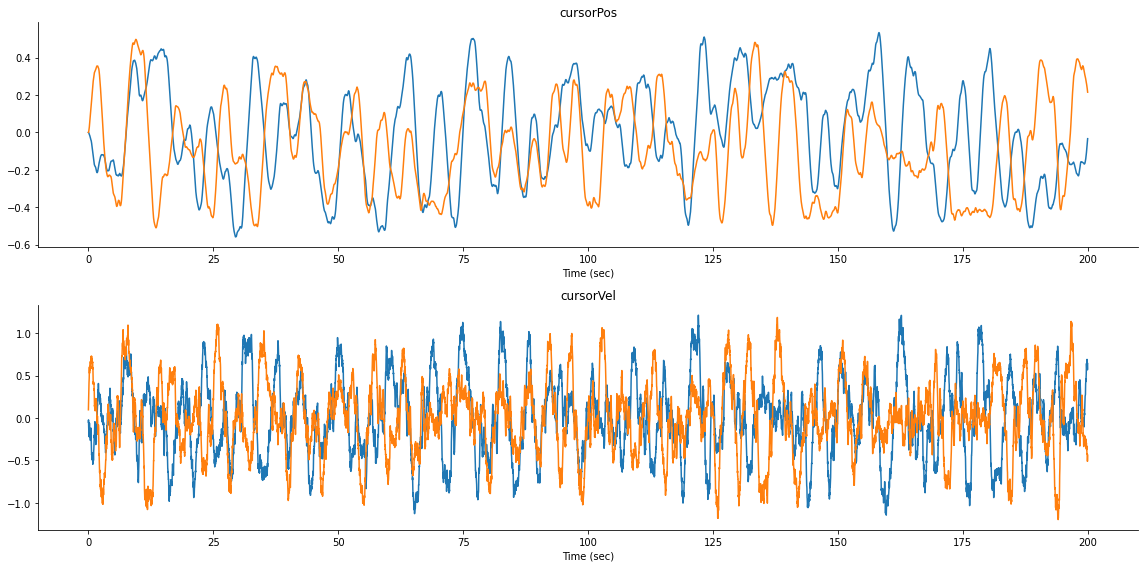

In [21]:
# plot cursor trajectories and velocities from this simulated session 
fig, axs = plt.subplots(2, 1, figsize = (16, 8))

time_secs = np.arange(dat['cursorPos'].shape[0]) * 0.02

for i, field in enumerate(['cursorPos', 'cursorVel']):
    axs[i].plot(time_secs, dat[field])
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(field)
    axs[i].set_xlabel('Time (sec)')
    
plt.tight_layout()
plt.show()

Now let's see how well the old decoder's weights align with our channel tuning matrix, D. In our simulator, neural activity is just simple linear tuning to an intended velocity/force signal. This is encoded in a `channels x 3` matrix, "neuralTuning", which contains the baseline activity and X/Y-velocity component tuning of each channel.

If our decoder is really good, then it should be nearly perfectly correlated with the channel weights ($\rho = 1$). Let's see if that's true:

In [22]:
# remove column 1 from <neuralTuning>, which holds baseline firing rates.
# also remove 1st row from <D>, as this contains the bias/intercept terms of our linear regression decoder
weight_corr = np.corrcoef(dat['neuralTuning'][:, 1:].flatten(), dat['D'][1:, :].flatten())[0, 1]
print('Correlation between decoder readout weights and neural tuning:', weight_corr)

Correlation between decoder readout weights and neural tuning: 0.5014065838454346


It looks like our decoder isn't optimal. Thankfully we have a PRI-T straightforward way to deal with this. Let's build a PRI-T HMM and use it to infer target positions from our closed-loop simulation data.

In [28]:
from PRIT.prit_utils import generateTargetGrid, generateTransitionMatrix
from PRIT.prit import HMMRecalibration

gridSize  = 20      # number of rows/columns when discretizing screen
stayProb  = 0.999  # probability that target just stays where it is at any given timestep
vmKappa   = 2       # precision parameter for the von mises distribution.
adjustKappa = lambda x: 1 / (1 + np.exp(-1 * (x - 0.) * 32.)) # our kappa weighting function


nStates                 = gridSize**2
targLocs                = generateTargetGrid(gridSize = gridSize, is_simulated=True)
stateTrans, pStateStart = generateTransitionMatrix(gridSize = gridSize, stayProb = stayProb)


# create a PRI-T HMM object
hmm = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa, adjustKappa = adjustKappa)

'''
Infer target locations from the smoothed decoder output and cursor positions using the viterbi algorithm (finds most likely sequence) and the
forwards/backwards algorithm (to find the probabilities). The predict() method returns:

targStates (1D array) - Viterbi target state sequence; need to index into targLocs to convert to position
pTargState (2D array) - time x nStates of occupation probabilities '''

targStates, pTargState = hmm.predict([dat['cursorPos']], [dat['cursorVel']])
inferredTargLoc  = hmm.targLocs[targStates.astype('int').flatten(),:]

Correlation between inferred target locations and true locations:  [0.82736182 0.81345784]


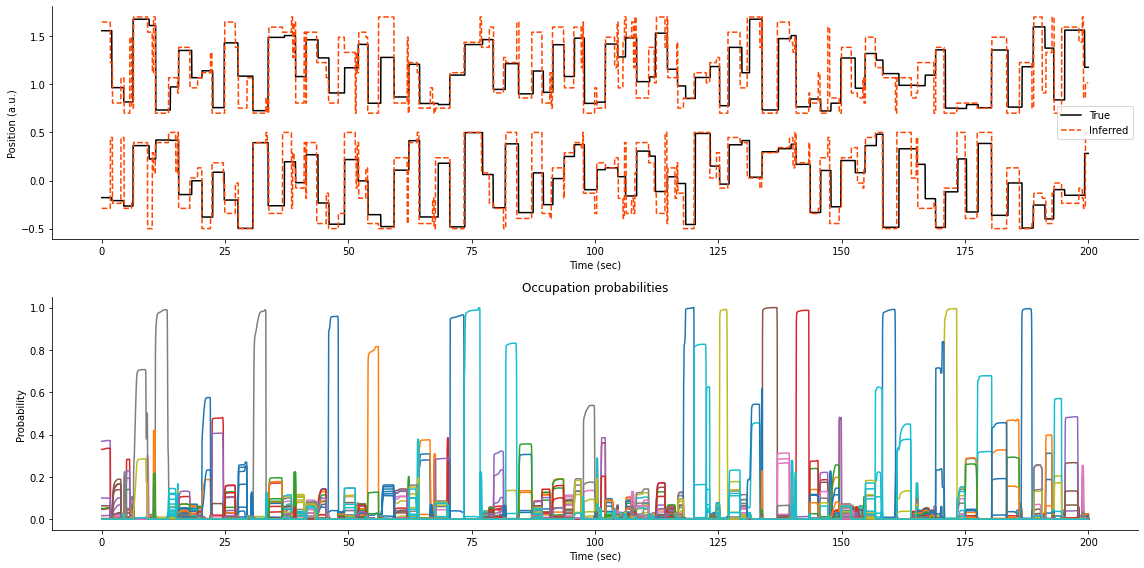

In [29]:
fig, axs = plt.subplots(2, 1, figsize = (16, 8))

print('Correlation between inferred target locations and true locations: ', np.diag(np.corrcoef(dat['targetPos'].T, inferredTargLoc.T), 2))


labels = ['X', 'Y']
for i in range(2):
    axs[0].plot(time_secs, dat['targetPos'][:, i] + i * 1.2,     c = 'k', label = 'True' if i else None)
    axs[0].plot(time_secs, inferredTargLoc[:, i] + i * 1.2,'--', c = 'orangered',label = 'Inferred' if i else None)
    
axs[0].set_xlabel('Time (sec)')
axs[0].set_ylabel('Position (a.u.)')
axs[0].legend()

axs[1].plot(time_secs, pTargState[:, :].T)
plt.title('Occupation probabilities')
plt.xlabel('Time (sec)')
plt.ylabel('Probability')


for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Looks like it does okay! Let's retrain our linear decoder using these inferred positions. We'll use weighted least squares to downweight low-probability timesteps and upweight high-probability ones.

In [26]:
from sklearn.linear_model import LinearRegression


inferredPosErr = inferredTargLoc - dat['cursorPos']
new_D = LinearRegression().fit(dat['neuralActivity'], inferredPosErr, np.max(pTargState, axis = 0)**2).coef_.T

weight_corr = np.corrcoef(dat['neuralTuning'][:, 1:].flatten(), new_D.flatten())[0, 1]
print('Correlation between decoder readout weights and neural tuning:', weight_corr)

Correlation between decoder readout weights and neural tuning: 0.913959172607106


Yay, it worked! If we were theoretically using this for real control, we'd now just deploy <new_D> as the new decoder. We took a bunch of steps here for making things more intuitive. If you want to quickly retrain your decoder though, you can do it in just a couple lines of code assuming it's an sklearn-style object.

In [27]:
import copy 

# make a sklearn-style linear decoder 
old_decoder = LinearRegression()
old_decoder.coef_ = dat['D'][1:, :].T
old_decoder.intercept_ = dat['D'][1, :][None, :]


# instantiate a PRIT HMM like before
#cursorVel, vmKappa = None, 0.25
cursorVel, vmKappa = [dat['cursorVel']], 2
hmm = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa,
                       adjustKappa = adjustKappa)

# recalibrate - we wrap observations in a list in case we want to process non-contiguous stretches
new_decoder = hmm.recalibrate(copy.deepcopy(old_decoder), [dat['neuralActivity']], [dat['cursorPos']], cursorVel = cursorVel)


# now let's check again:
new_weights = new_decoder.coef_.T
weight_corr = np.corrcoef(dat['neuralTuning'][:, 1:].flatten(), new_weights.flatten())[0, 1]
print('Correlation between decoder readout weights and neural tuning:', weight_corr)

Correlation between decoder readout weights and neural tuning: 0.913959172607106


Note that we pass the smoothed velocities for inference here. This works well, and we'd recommend testing with this approach instead of the raw velocities (see below) for any online experiments.

In the paper, we used the raw velocities. This turns out to work substantially worse (uncomment line 8 to see; you should get $\rho = 0.58$). We saved things a little by setting `vmKappa = 0.25`, which tells the model to expect noisier distributions of velocity angles. 

### Using a click signal

We can optionally add a click signal to PRI-T's observation model for improved performance.

Text(0, 0.5, 'Click state')

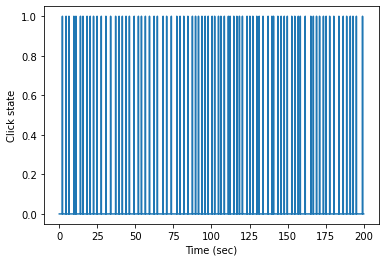

In [15]:
clickSignal = dat['clickState'].flatten() # this will need to be a 1D binary array recording the clicks 

plt.plot(time_secs, clickSignal)
plt.xlabel('Time (sec)')
plt.ylabel('Click state')

To do so, we'll modify two things:
- the `HMMRecalibration` object receives a new argument `getClickProb`. This is a mapping from distance --> P(click | distance). 
- The `recalibrate()` method receives a new argument `clickSignal` for inference, which is a list containing 1D binary arrays of click states.


Since the simulator here had dwell-based clicks and only one active target at a given time, all clicks were real clicks over the target. So we'll let `getClickProb(dist) = p if over target, 0 else`. We'll sweep for the value of `p`:

In [16]:
# instantiate a PRIT HMM like before: we'll use the raw decoded velocities again
adjustKappa        = lambda x: 1 / (1 + np.exp(-1 * (x - 0.) * 32.))
cursorVel, vmKappa = None, 0.25

for p in [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]:
    getClickProb = lambda x: p * (x < 0.075).astype(int) # target radius in simulator is 0.075
    hmm = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa,
                           adjustKappa = adjustKappa, getClickProb=getClickProb)

    # build a new decoder - this time, we set probThreshold = 0 as weighting seems not to play well with click
    new_decoder = hmm.recalibrate(copy.deepcopy(old_decoder), [dat['neuralActivity']], [dat['cursorPos']], 
                                  cursorVel = cursorVel, clickSignal = [clickSignal], probThreshold=0.)

    # measure decoder correlation with tuning weights:
    new_weights = new_decoder.coef_.T
    weight_corr = np.corrcoef(dat['neuralTuning'][:, 1:].flatten(), new_weights.flatten())[0, 1]
    print(f'p = {p}, correlation:', weight_corr)

/home/users/ghwilson/.local/lib/python3.9/site-packages/PRIT/prit.py:74: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))


p = 1, correlation: 0.7142046329915366


/home/users/ghwilson/.local/lib/python3.9/site-packages/PRIT/prit.py:74: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))


p = 0.9, correlation: 0.7457940598432518


/home/users/ghwilson/.local/lib/python3.9/site-packages/PRIT/prit.py:74: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))


p = 0.8, correlation: 0.7695362006011612


/home/users/ghwilson/.local/lib/python3.9/site-packages/PRIT/prit.py:74: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))


p = 0.7, correlation: 0.7788928335605434


/home/users/ghwilson/.local/lib/python3.9/site-packages/PRIT/prit.py:74: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))


p = 0.6, correlation: 0.7850114296019245


/home/users/ghwilson/.local/lib/python3.9/site-packages/PRIT/prit.py:74: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))


p = 0.5, correlation: 0.7768967164681949


/home/users/ghwilson/.local/lib/python3.9/site-packages/PRIT/prit.py:74: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))


p = 0.4, correlation: 0.7652703389191269


Doing better! But here we're kinda cheating - all the clicks are accurate target selections. What if we corrupt 20% of the clicks to be at random timepoints? Let's try that without modifying our observation model.

In [17]:
fp_rate = 0.2 # we'll make ~ 20% of the overall clicks fake

num_fake = int(sum(clickSignal) * fp_rate / (1 - fp_rate)) # will randomly flip this many timesteps to a click
clickSignal_noisy = np.copy(clickSignal)
clickSignal_noisy[np.random.choice(len(clickSignal_noisy), num_fake, replace= False)] = 1

In [18]:
# build a new decoder
cursorVel, vmKappa = None, 0.25
new_decoder = hmm.recalibrate(copy.deepcopy(old_decoder), [dat['neuralActivity']], [dat['cursorPos']], 
                              cursorVel = cursorVel, clickSignal = [clickSignal_noisy], probThreshold=0.)

# now let's check again:
new_weights = new_decoder.coef_.T
weight_corr = np.corrcoef(dat['neuralTuning'][:, 1:].flatten(), new_weights.flatten())[0, 1]
print('Correlation without accounting for noise:', weight_corr)


/home/users/ghwilson/.local/lib/python3.9/site-packages/PRIT/prit.py:74: RuntimeWarning: divide by zero encountered in log
  obsProbLog  += np.log(clickState[:, None] * probClick + ((1 - clickState)[:, None] * (1 - probClick)))


Correlation without accounting for noise: 0.756890329753273


Still higher than the velocity-only model ($\rho = 0.58$).